In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.metrics import mean_squared_error
sns.set(font='Arial')

from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order
from statsmodels.tsa.seasonal import STL
plt.rc("figure", figsize=(16, 10))

In [11]:
df = pd.read_csv('..\\data\\pareto\\acasmmura_q.csv',index_col=0)
df=df.join(pd.read_csv('..\\data\\pareto\\acassmura_q.csv',index_col=0))

df.index=df.index.rename('Date')
df.index=pd.DatetimeIndex(df.index,freq='QS-OCT')

In [12]:
df=df*1000

<AxesSubplot:xlabel='Date'>

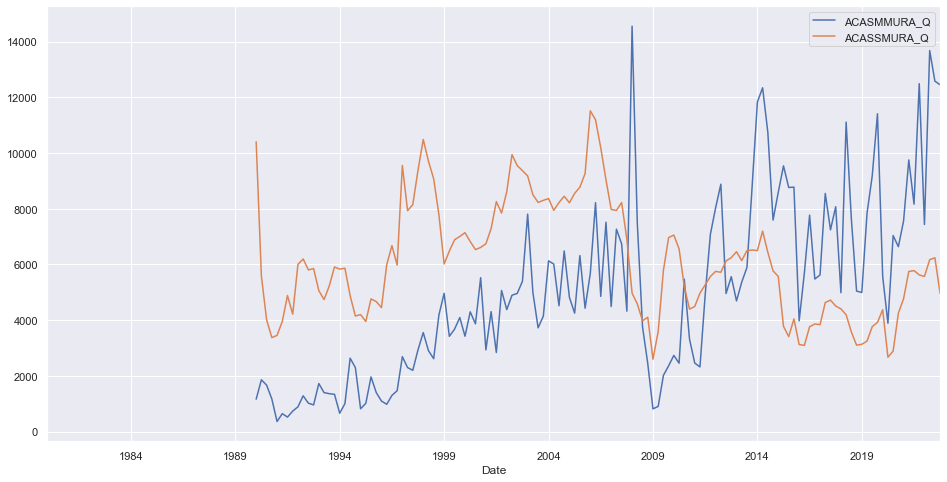

In [13]:
df.plot(figsize=(16,8))

In [14]:
nat_var = pd.read_excel('../data/hmo_2023_variables.xlsx',sheet_name='national',engine='openpyxl',index_col=0)
prov_var=pd.read_excel('../data/hmo_2023_variables.xlsx',sheet_name='provincial',engine='openpyxl',index_col=0)
covid = pd.read_excel('../data/hmo_2023_variables.xlsx',sheet_name='covid_dummy',engine='openpyxl',index_col=0)
wti = pd.read_excel('../data/hmo_2023_variables.xlsx',sheet_name='wti',engine='openpyxl',index_col=0)


nat_var.index = nat_var.index.str.replace(' ','')
nat_var.index = nat_var.index.rename('Date')
nat_var.index = pd.PeriodIndex(nat_var.index,freq='Q').to_timestamp()

prov_var.index = prov_var.index.rename('Date')
prov_var.index = pd.PeriodIndex(prov_var.index,freq='Q').to_timestamp()


covid.index = covid.index.str.replace(' ','')
covid.index = covid.index.rename('Date')
covid.index = pd.PeriodIndex(covid.index,freq='Q').to_timestamp()

wti.index=wti.index.str.replace(' ','')
wti.index = wti.index.rename('Date')
wti.index = pd.PeriodIndex(wti.index,freq='Q').to_timestamp()

In [15]:
prov_var = prov_var.join(nat_var)
prov_var = prov_var.join(covid)
prov_var = prov_var.join(wti)

In [16]:
prov_var.columns

Index(['gdp_AB_2023', 'gdp_AB_2023_alt', 'unemp_AB_2023', 'unemp_AB_2023_alt',
       'emp_AB_2023', 'emp_AB_2023_alt', 'cpi_AB_2023', 'cpi_AB_2023_alt',
       'cpiyoy_AB_2023', 'cpiyoy_AB_2023_alt', 'policy_rate_base',
       'policy_rate_alt', 'Interest rate, 10-Year Benchmark Bond Yield',
       '5_year_mortgage_base', '5_year_mortgage_alt', 'COVID-19', 'Long COVID',
       'WTI_base', 'WTI_lower', 'WTI_upper'],
      dtype='object')

In [17]:
df = prov_var.join(df)

In [18]:
df.columns

Index(['gdp_AB_2023', 'gdp_AB_2023_alt', 'unemp_AB_2023', 'unemp_AB_2023_alt',
       'emp_AB_2023', 'emp_AB_2023_alt', 'cpi_AB_2023', 'cpi_AB_2023_alt',
       'cpiyoy_AB_2023', 'cpiyoy_AB_2023_alt', 'policy_rate_base',
       'policy_rate_alt', 'Interest rate, 10-Year Benchmark Bond Yield',
       '5_year_mortgage_base', '5_year_mortgage_alt', 'COVID-19', 'Long COVID',
       'WTI_base', 'WTI_lower', 'WTI_upper', 'ACASMMURA_Q', 'ACASSMURA_Q'],
      dtype='object')

In [99]:
sel_res = ardl_select_order(df['ACASMMURA_Q']['1996':'2022'],4,df[['unemp_AB_2023','WTI_upper','5_year_mortgage_base']]['1996':'2022'],ic='aic',trend='t',maxorder=12)

In [100]:
res = sel_res.model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:            ACASMMURA_Q   No. Observations:                  108
Model:                  ARDL(1, 8, 0)   Log Likelihood                -955.024
Method:               Conditional MLE   S.D. of innovations           1819.869
Date:                Fri, 24 Feb 2023   AIC                           1936.048
Time:                        10:28:35   BIC                           1970.795
Sample:                    01-01-1998   HQIC                          1950.134
                         - 10-01-2022                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
trend                      50.4406     14.634      3.447      0.001      21.388      79.493
ACASMMURA_Q.L1              0.3901      0.097      4.025      0.000       0.198       0.582
unemp_AB_2023.L0         -596.2976    259.921     -2.294      0.024   -1112.306     -80.289
unemp_AB_2023.L1          411.2918    353.779      1.163      0.248    -291.049    1113.633
unemp_AB_2023.L2         -332.5287    352.657     -0.943      0.348   -1032.641     367.583
unemp_AB_2023.L3          250.6988    352.285      0.712      0.478    -448.675     950.072
unemp_AB_2023.L4          287.3518    351.905      0.817      0.416    -411.267     985.971
unemp_AB_2023.L5         -577.6889    352.927     -1.637      0.105   -1278.337     122.959
unemp_AB_2023.L6          719.5358    355.964      2.021      0.046      12.859    1426.213
unemp_AB_2023.L7         -990.0894    357.201     -2.772      0.007   -1699.222    -280.956
unemp_AB_2023.L8          755.7297    267.557      2.825      0.006     224.562    1286.898
5_year_mortgage_base.L0   237.7217    125.764      1.890      0.062     -11.950     487.394
===========================================================================================
"""

In [101]:
predict = res.get_prediction(start=100,end=119, exog_oos=df[['unemp_AB_2023','WTI_upper','5_year_mortgage_base']]['2023':'2025'])
predict_ci = predict.conf_int(alpha=0.7)

<AxesSubplot:xlabel='Date'>

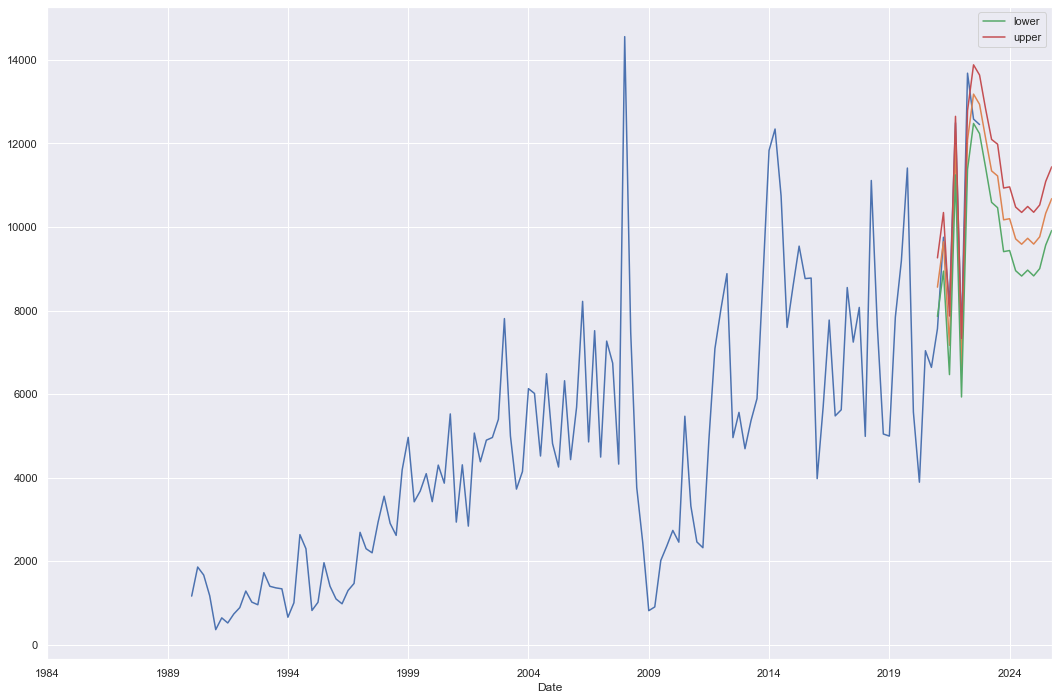

In [102]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(18,12))

df['ACASMMURA_Q'][:'2022'].plot(ax=ax)

predict.predicted_mean.plot(ax=ax)
predict_ci.plot(ax=ax)

In [105]:
(df['ACASMMURA_Q']/4)[:'2022'].resample('A').mean()['2010':]

Date
2010-12-31     873.9375
2011-12-31    1048.7500
2012-12-31    1714.8125
2013-12-31    1548.1875
2014-12-31    2657.2500
2015-12-31    2229.6875
2016-12-31    1432.7500
2017-12-31    1843.2500
2018-12-31    1798.4375
2019-12-31    2089.6250
2020-12-31    1446.0625
2021-12-31    2373.5000
2022-12-31    2884.2500
Freq: A-DEC, Name: ACASMMURA_Q, dtype: float64

In [106]:
predict.predicted_mean.resample('A').mean()

2021-12-31     9329.123381
2022-12-31    11206.588871
2023-12-31    11215.578201
2024-12-31     9806.826085
2025-12-31    10089.903854
Freq: A-DEC, Name: predicted_mean, dtype: float64

In [ ]:
predict.predicted_mean.to_csv('multi_starts_fcast_23.csv')

In [89]:
sfd_sel_res = ardl_select_order(df['ACASSMURA_Q']['1996':'2022'],8,df[['emp_AB_2023','WTI_upper','5_year_mortgage_base']]['1996':'2022'],ic='aic',trend='n',maxorder=12)

In [90]:
sfd_res = sfd_sel_res.model.fit()
sfd_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:            ACASSMURA_Q   No. Observations:                  108
Model:                  ARDL(5, 1, 3)   Log Likelihood                -811.838
Method:               Conditional MLE   S.D. of innovations            640.969
Date:                Fri, 24 Feb 2023   AIC                           1647.675
Time:                        00:03:08   BIC                           1679.292
Sample:                    04-01-1997   HQIC                          1660.481
                         - 10-01-2022                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
ACASSMURA_Q.L1              1.0043      0.094     10.736      0.000       0.819       1.190
ACASSMURA_Q.L2             -0.0254      0.131     -0.194      0.847      -0.286       0.235
ACASSMURA_Q.L3              0.0068      0.123      0.055      0.956      -0.237       0.251
ACASSMURA_Q.L4             -0.2539      0.122     -2.075      0.041      -0.497      -0.011
ACASSMURA_Q.L5              0.1644      0.084      1.949      0.054      -0.003       0.332
WTI_upper.L0               15.3546      6.726      2.283      0.025       1.995      28.714
WTI_upper.L1              -14.3739      6.728     -2.136      0.035     -27.737      -1.011
5_year_mortgage_base.L0   606.6461    263.634      2.301      0.024      83.047    1130.245
5_year_mortgage_base.L1 -1065.6450    430.895     -2.473      0.015   -1921.440    -209.851
5_year_mortgage_base.L2  -333.0033    451.226     -0.738      0.462   -1229.177     563.170
5_year_mortgage_base.L3   888.8837    274.775      3.235      0.002     343.156    1434.611
===========================================================================================
"""

In [91]:
predict = sfd_res.get_prediction(start=100,end=119, exog_oos=df[['emp_AB_2023','WTI_upper','5_year_mortgage_base']]['2023':'2025'])
predict_ci = predict.conf_int(alpha=0.7)

<AxesSubplot:xlabel='Date'>

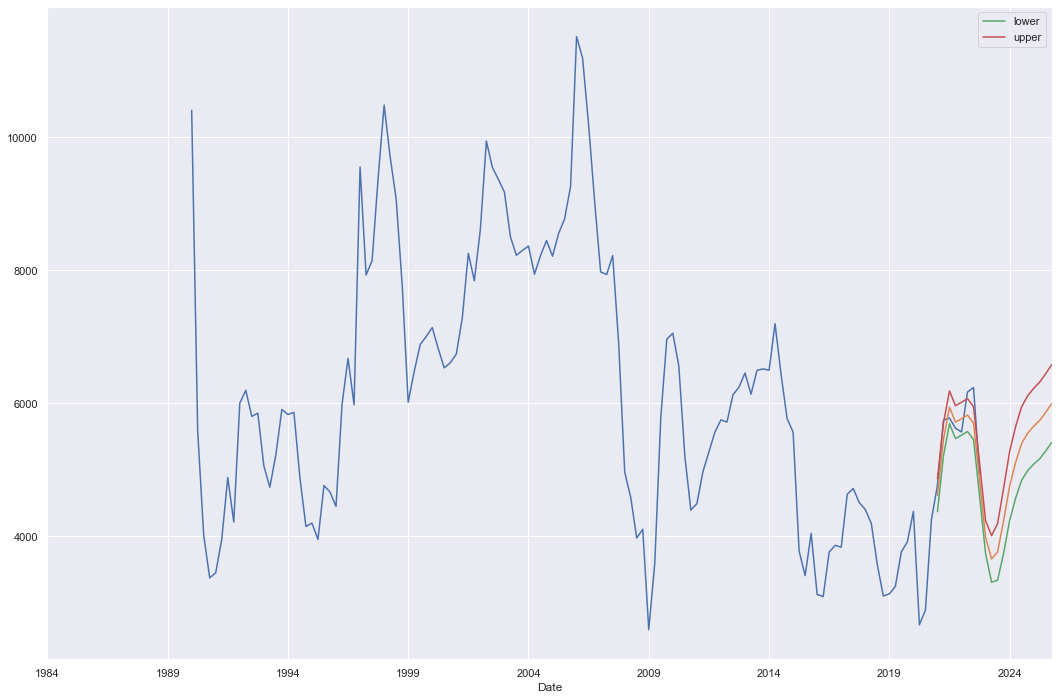

In [92]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(18,12))

df['ACASSMURA_Q'][:'2022'].plot(ax=ax)

predict.predicted_mean.plot(ax=ax)
predict_ci.plot(ax=ax)

In [93]:
predict.predicted_mean

2021-01-01    4619.324250
2021-04-01    5458.565224
2021-07-01    5941.893011
2021-10-01    5718.511203
2022-01-01    5771.384760
2022-04-01    5824.737696
2022-07-01    5703.844437
2022-10-01    4859.276749
2023-01-01    3990.596554
2023-04-01    3661.136303
2023-07-01    3767.674494
2023-10-01    4234.821324
2024-01-01    4757.823199
2024-04-01    5115.454508
2024-07-01    5398.915716
2024-10-01    5552.368676
2025-01-01    5657.667124
2025-04-01    5744.079331
2025-07-01    5866.558097
2025-10-01    5999.203239
Freq: QS-OCT, Name: predicted_mean, dtype: float64

In [98]:
predict_ci['upper'].to_csv('sfd_starts_fcast_23.csv')

In [95]:
predict.predicted_mean.resample('A').mean()

2021-12-31    5434.573422
2022-12-31    5539.810910
2023-12-31    3913.557169
2024-12-31    5206.140525
2025-12-31    5816.876948
Freq: A-DEC, Name: predicted_mean, dtype: float64

In [96]:
predict_ci['upper'].resample('A').mean()

2021-12-31    5681.551788
2022-12-31    5786.789277
2023-12-31    4291.465851
2024-12-31    5749.182169
2025-12-31    6395.146118
Freq: A-DEC, Name: upper, dtype: float64

In [97]:
df['ACASSMURA_Q']['2000':'2022'].resample('A').mean()

Date
2000-12-31     6777.50
2001-12-31     7533.75
2002-12-31     9370.50
2003-12-31     8553.50
2004-12-31     8246.00
2005-12-31     8701.75
2006-12-31    10484.25
2007-12-31     7761.25
2008-12-31     4410.25
2009-12-31     4738.00
2010-12-31     5805.50
2011-12-31     5076.25
2012-12-31     5961.75
2013-12-31     6403.75
2014-12-31     6476.50
2015-12-31     4201.50
2016-12-31     3463.25
2017-12-31     4425.25
2018-12-31     3820.00
2019-12-31     3518.00
2020-12-31     3547.50
2021-12-31     5481.75
2022-12-31     5733.75
Freq: A-DEC, Name: ACASSMURA_Q, dtype: float64